In [1]:
import numpy as np                    
import pandas as pd                  
import matplotlib.pyplot as plt       
import seaborn as sns               
import warnings                     
import time
import datetime
import xgboost
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('PUBG.csv')

print('There are {:,} rows and {} columns in our dataset.'.format(train.shape[0],train.shape[1]))

There are 4,446,966 rows and 29 columns in our dataset.


In [3]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


# Columns descriptions:

**groupId** - Players team ID <br>
**matchId** - Match ID <br>
**assists** - Number of assisted kills. The killed is actually scored for the another teammate.<br>
**boosts** - Number of boost items used by a player. These are for example: energy dring, painkillers, adrenaline syringe.<br>
**damageDealt** - Damage dealt to the enemy<br>
**DBNOs** - Down But No Out - when you lose all your HP but you're not killed yet. All you can do is only to crawl.<br>
**headshotKills** - Number of enemies killed with a headshot<br>
**heals** - Number of healing items used by a player. These are for example: bandages, first-aid kits<br>
**killPlace** - Ranking in a match based on kills.<br>
**killPoints** - Ranking in a match based on kills points.<br>
**kills** - Number of enemy players killed.<br>
**killStreaks** - Max number of enemy players killed in a short amount of time.<br>
**longestKill** - Longest distance between player and killed enemy.<br>
**matchDuration** - Duration of a mach in seconds.<br>
**matchType** - Type of match. There are three main modes: Solo, Duo or Squad. In this dataset however we have much more categories.<br>
**maxPlace** - The worst place we in the match.<br>
**numGroups** - Number of groups (teams) in the match.<br>
**revives** - Number of times this player revived teammates.<br>
**rideDistance** - Total distance traveled in vehicles measured in meters.<br>
**roadKills** - Number of kills from a car, bike, boat, etc.<br>
**swimDistance** - Total distance traveled by swimming (in meters).<br>
**teamKills** - Number teammate kills (due to friendly fire).<br>
**vehicleDestroys** - Number of vehicles destroyed.<br>
**walkDistance** - Total distance traveled on foot measured (in meters).<br>
**weaponsAcquired** - Number of weapons picked up.<br>
**winPoints** - Ranking in a match based on won matches.<br>

Target column: <br>
**winPlacePerc** - Normalised placement (rank). The 1st place is 1 and the last one is 0.<br>

# Data Preprocessing and Data Visualization

In [4]:
#check missing data
train.isna().any()

Id                 False
groupId            False
matchId            False
assists            False
boosts             False
damageDealt        False
DBNOs              False
headshotKills      False
heals              False
killPlace          False
killPoints         False
kills              False
killStreaks        False
longestKill        False
matchDuration      False
matchType          False
maxPlace           False
numGroups          False
rankPoints         False
revives            False
rideDistance       False
roadKills          False
swimDistance       False
teamKills          False
vehicleDestroys    False
walkDistance       False
weaponsAcquired    False
winPoints          False
winPlacePerc        True
dtype: bool

In [5]:
#drop null value
train=train.dropna(axis=0)
print('After dropping null, there are {:,} rows left in our dataset.'.format(train.shape[0]))

After dropping null, there are 4,446,965 rows left in our dataset.


In [6]:
#drop ID
train = train.drop(columns=['Id', 'groupId', 'matchId'])

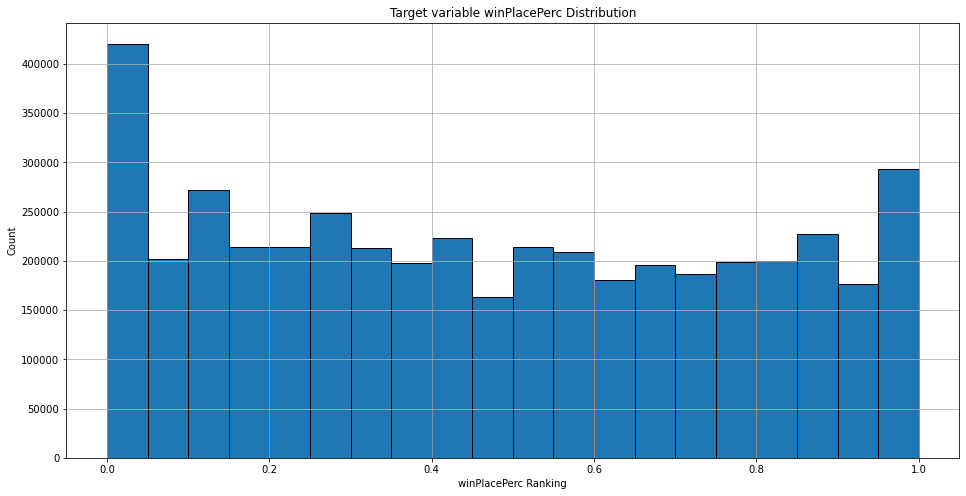

In [7]:
# Distribution of target variable
dist = train
dist.hist('winPlacePerc', bins=20, figsize = (16,8), edgecolor='black')
plt.title("Target variable winPlacePerc Distribution")
plt.xlabel("winPlacePerc Ranking")
plt.ylabel("Count")
plt.show()

In [8]:
# Analyze Categorical Data
m_types = train.loc[:,"matchType"].value_counts().to_frame().reset_index()
m_types.columns = ["Type","Count"]
m_types

,Type,Count
0,squad-fpp,1756186
1,duo-fpp,996691
2,squad,626526
3,solo-fpp,536761
4,duo,313591
5,solo,181943
6,normal-squad-fpp,17174
7,crashfpp,6287
8,normal-duo-fpp,5489
9,flaretpp,2505


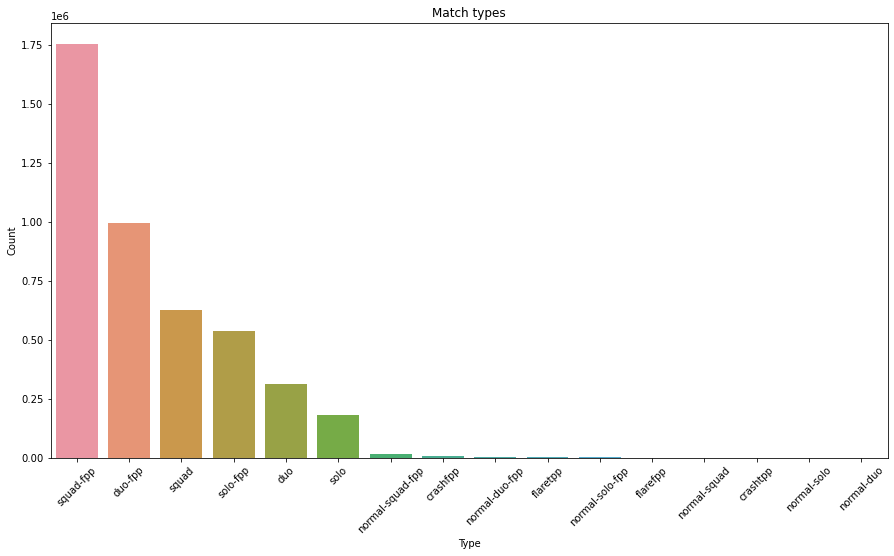

In [9]:
plt.figure(figsize=(15,8))
ticks = m_types.Type.values
ax = sns.barplot(x="Type", y="Count", data=m_types)
ax.set_xticklabels(ticks, rotation=45)
ax.set_title("Match types")
plt.show()

In [10]:
# Choose the most important types of matches to study
mathtype2num={'squad-fpp':0,'duo-fpp':1,'squad':2,'squad-fpp':3,'duo':4, 'solo':5}
train['matchType']=train['matchType'].map(mathtype2num)
train['matchType'].value_counts()

3.0    1756186
1.0     996691
2.0     626526
4.0     313591
5.0     181943
Name: matchType, dtype: int64

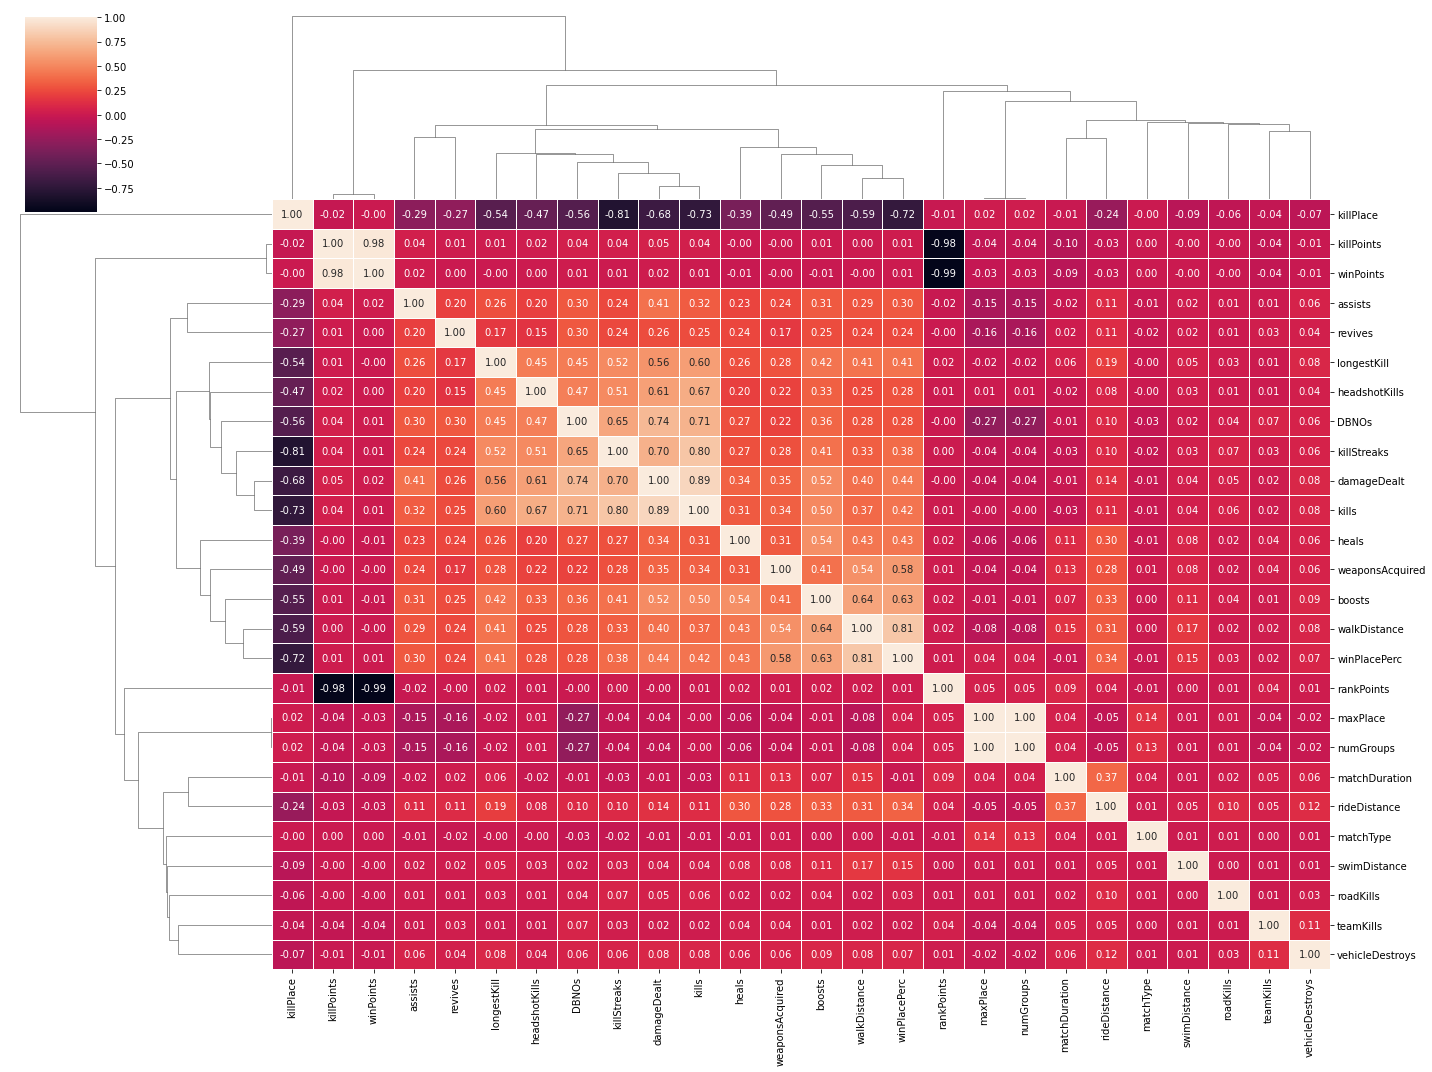

In [11]:
#Check whether there are highly correlated features
ax = sns.clustermap(train.corr(), annot=True, linewidths=.6, fmt= '.2f', figsize=(20, 15))
plt.show()

In [12]:
# drop maxPlace, which seems to have a linear realtionship with numGroups (value of 1.0)
train = train.drop(columns=['maxPlace'])
train.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.00,0,0,0,60,1241,0,0,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,0,0,91.47,0,0,0,57,0,0,0,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1,0,68.00,0,0,0,47,0,0,0,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,0,0,32.90,0,0,0,75,0,0,0,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,0,0,100.00,0,0,0,45,0,1,1,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


# Data Sampling

In [13]:
# X_train and y_train
X = train.drop(columns = ['winPlacePerc'])
y = train['winPlacePerc']

In [14]:
# Split training dataset and validation dataset
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=42)

# Model Training & Evaluation

In [15]:
#Baseline Model
from sklearn.metrics import mean_absolute_error
start_time = datetime.datetime.now()

xgbmodel = XGBRegressor()
xgbmodel.fit(X_train, y_train)

y_pred = xgbmodel.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)

end_time = datetime.datetime.now()

time_elapsed = end_time - start_time

print("Total training time takes (seconds): ", time_elapsed.total_seconds())
print("MAE on validation data: {}".format(mae))

Total training time takes (seconds):  523.093419
MAE on validation data: 0.05838880481805709


In [28]:
y_pred = xgbmodel.predict(X_train)

mae = mean_absolute_error(y_train, y_pred)

print("MAE on training data: {}".format(mae))

MAE on training data: 0.058012854113166


In [16]:
y_pred = xgbmodel.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print("MAE on testing data: {}".format(mae))

MAE on testing data: 0.0583844201140139


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

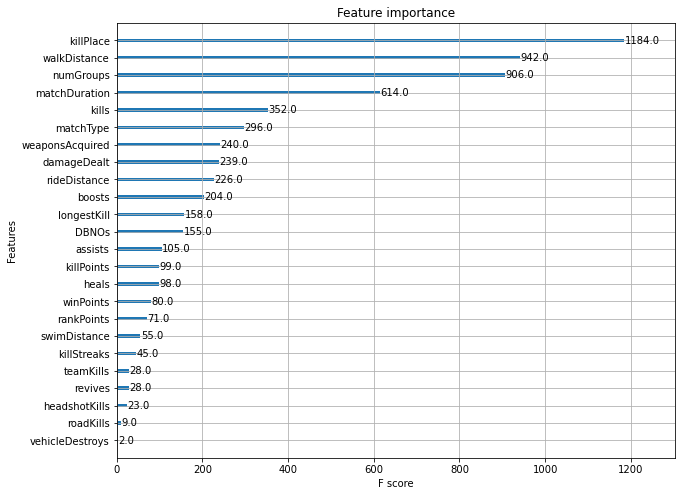

In [25]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
xgboost.plot_importance(xgbmodel, ax= ax)

In [ ]:
# Hyperparameters training
import pickle
start_time = datetime.datetime.now()
params = {  
    "n_estimators": [800,1000, 1200],
    "learning_rate": [0.05,0.1,0.2],
    "gamma": [1,3,5],
    "min_child_weight": [5,7],
}

t=time.localtime()
print(time.asctime(t))

xgbmodel = XGBRegressor()  
RSCxgb = RandomizedSearchCV(xgbmodel, params, cv=10)

model=RSCxgb.fit(X_train, y_train)

y_pred = xgbmodel.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print("MAE on training data: {}".format(mae))

y_pred = xgbmodel.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print("MAE on validation data: {}".format(mae))

y_pred = xgbmodel.predict(X_test)
mae = mean_absolute_error(y_, y_pred)
print("MAE on training data: {}".format(mae))

end_time = datetime.datetime.now()
time_elapsed = end_time - start_time

print("Total training time takes (seconds): ", time_elapsed.total_seconds())
print("MAE: {}".format(mae))

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)